This notebook analyzes a video capture from the laser camera where a far mirror was set up 2.35m across the room.  The laser diode and camera were both placed on the vibration isolated mount of the STM.  In front of the laser diode, a ø2mm apterture was placed to somewhat contain the beam spread.

From the video, we recover the center position of the laser in each frame.  Then we can analyze the movement of the laser beam over time and extract frequency content.  This should give us an indication of the transmittance of the vibration isolation over time.

In [177]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import time

capture = cv2.VideoCapture("./laser-img/2025-09-07-011400.webm")

Fetch video capture metadata for processing:

In [178]:
frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = int(capture.get(cv2.CAP_PROP_FPS))
frame_time = 1 / frame_rate
frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Overwrite frame_count for limiting analysis window
frame_count = 3000

print(f"Capture Info: {frame_count} frames with dimension {frame_width}×{frame_height} at {frame_rate} Hz, totalling {frame_count * frame_time:.2f} seconds")

Capture Info: 3000 frames with dimension 1920×1080 at 30 Hz, totalling 100.00 seconds


## Laser Beam Position Recovery
The laser beam position is recovered using the `ndimage.center_of_mass()` function.  This function hinges on the background of the image being completely dark — otherwise there will be a positional bias towards the center of the image.

In [179]:
def find_laser_beam(image):
    image_monochrome = np.mean(image, axis=2)
    intensity = np.mean(image)
    y, x = ndimage.center_of_mass(image_monochrome)
    return np.array((x, y, intensity))

## Video Capture Processing
Process the capture frame by frame to recover the laser beam position in each frame.  For verification of the recovery function, a few shots from the capture are visualized.

Snapshot capture of frame      0 at   0.00s: Intensity 9.282
Snapshot capture of frame    333 at  11.10s: Intensity 10.440
Snapshot capture of frame    666 at  22.20s: Intensity 12.150
Snapshot capture of frame    999 at  33.30s: Intensity 12.801
Snapshot capture of frame   1332 at  44.40s: Intensity 12.652
Snapshot capture of frame   1665 at  55.50s: Intensity 11.099
Snapshot capture of frame   1998 at  66.60s: Intensity 11.897
Snapshot capture of frame   2331 at  77.70s: Intensity 12.612
Snapshot capture of frame   2664 at  88.80s: Intensity 12.257
Snapshot capture of frame   2997 at  99.90s: Intensity 12.728
Video processing took 251.50 seconds (0.084 seconds per frame).


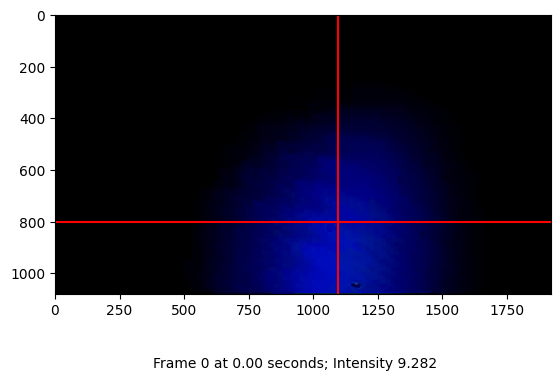

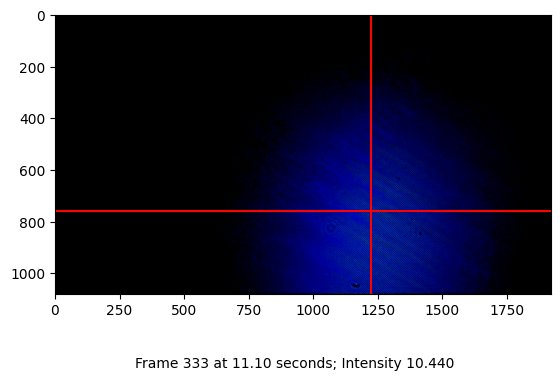

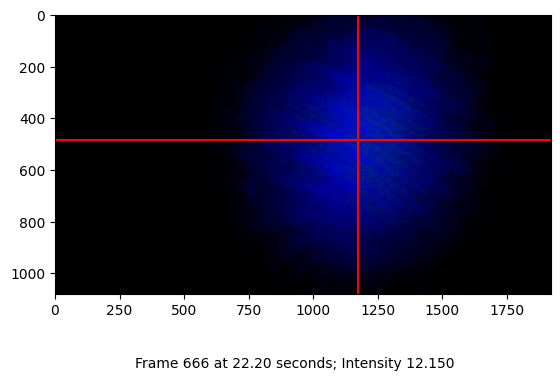

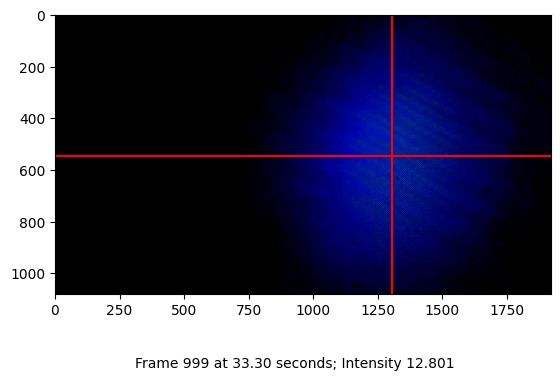

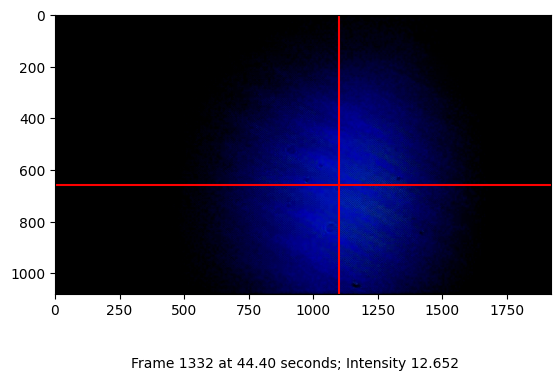

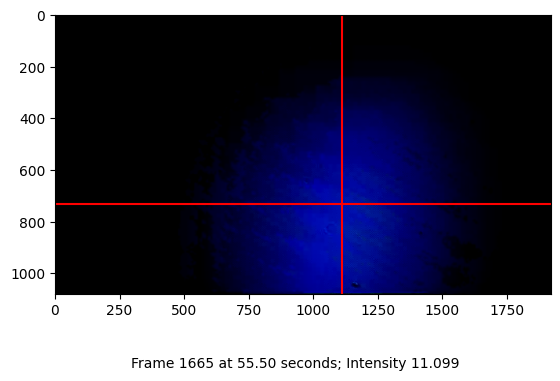

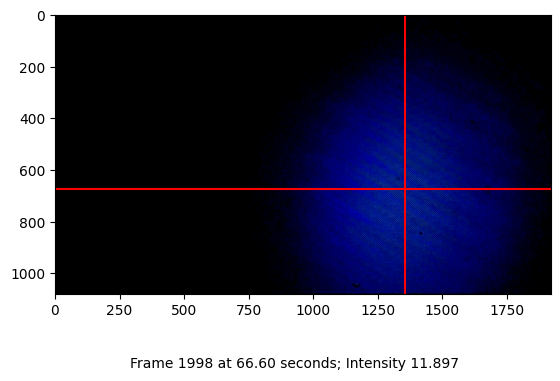

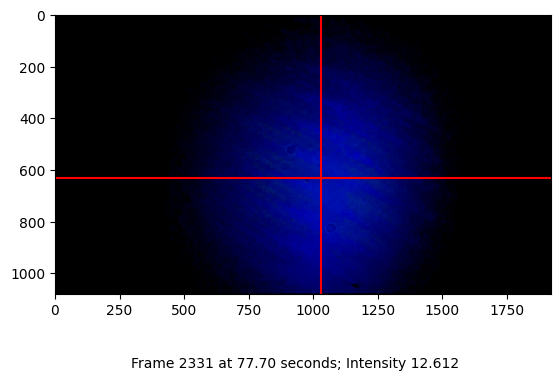

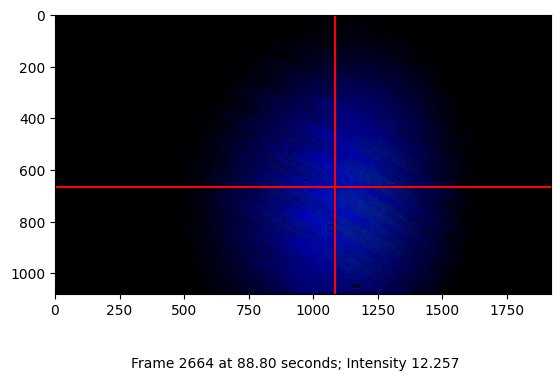

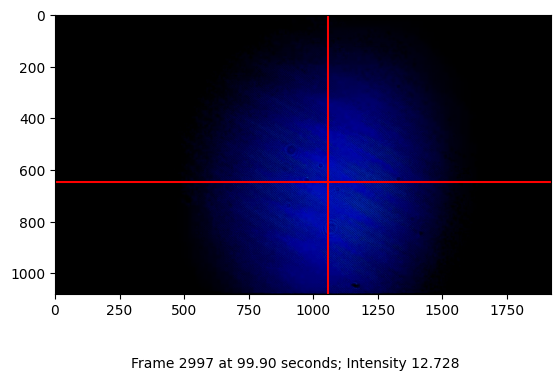

In [180]:
processing_start = time.monotonic()

laser_position = np.empty((frame_count, 3), np.dtype('float32'))

current_frame = 0
ret = True
while current_frame < frame_count and ret:
    ret, frame = capture.read()
    if ret:
        current_laser = find_laser_beam(frame)
        current_frame_time = current_frame * frame_time

        laser_position[current_frame] = current_laser

        if current_frame % (frame_count // 9) == 0:
            print(f"Snapshot capture of frame {current_frame:6} at {current_frame_time:6.2f}s: Intensity {current_laser[2]:.3f}")
            plt.figure()
            plt.imshow(frame)
            plt.axvline(x=current_laser[0], color="red")
            plt.axhline(y=current_laser[1], color="red")
            plt.figtext(0.5, 0.05, f"Frame {current_frame} at {current_frame_time:.2f} seconds; Intensity {current_laser[2]:.3f}", ha="center")
    
    current_frame += 1

processing_time = time.monotonic() - processing_start
print(f"Video processing took {processing_time:.2f} seconds ({processing_time / frame_count:.3f} seconds per frame).")

Derive data for the plots below from the raw analysis.

In [181]:
time_axis = np.linspace(0, frame_count * frame_time, frame_count)

laser_displacement_zeroed = laser_position[:, 0:2] - np.nanmean(laser_position[:, 0:2], axis=0)

velocity_xy = np.diff(laser_position[:, 0:2])
velocity_abs = np.nan_to_num(np.linalg.norm(velocity_xy, axis=1))

max_intensity = np.max(laser_position[:, 2])
laser_intensity = laser_position[:, 2] / max_intensity

### Time-dependent Laser Position and Intensity plots
The following figure shows the laser displacement, velocity, and intensity over the whole capture.

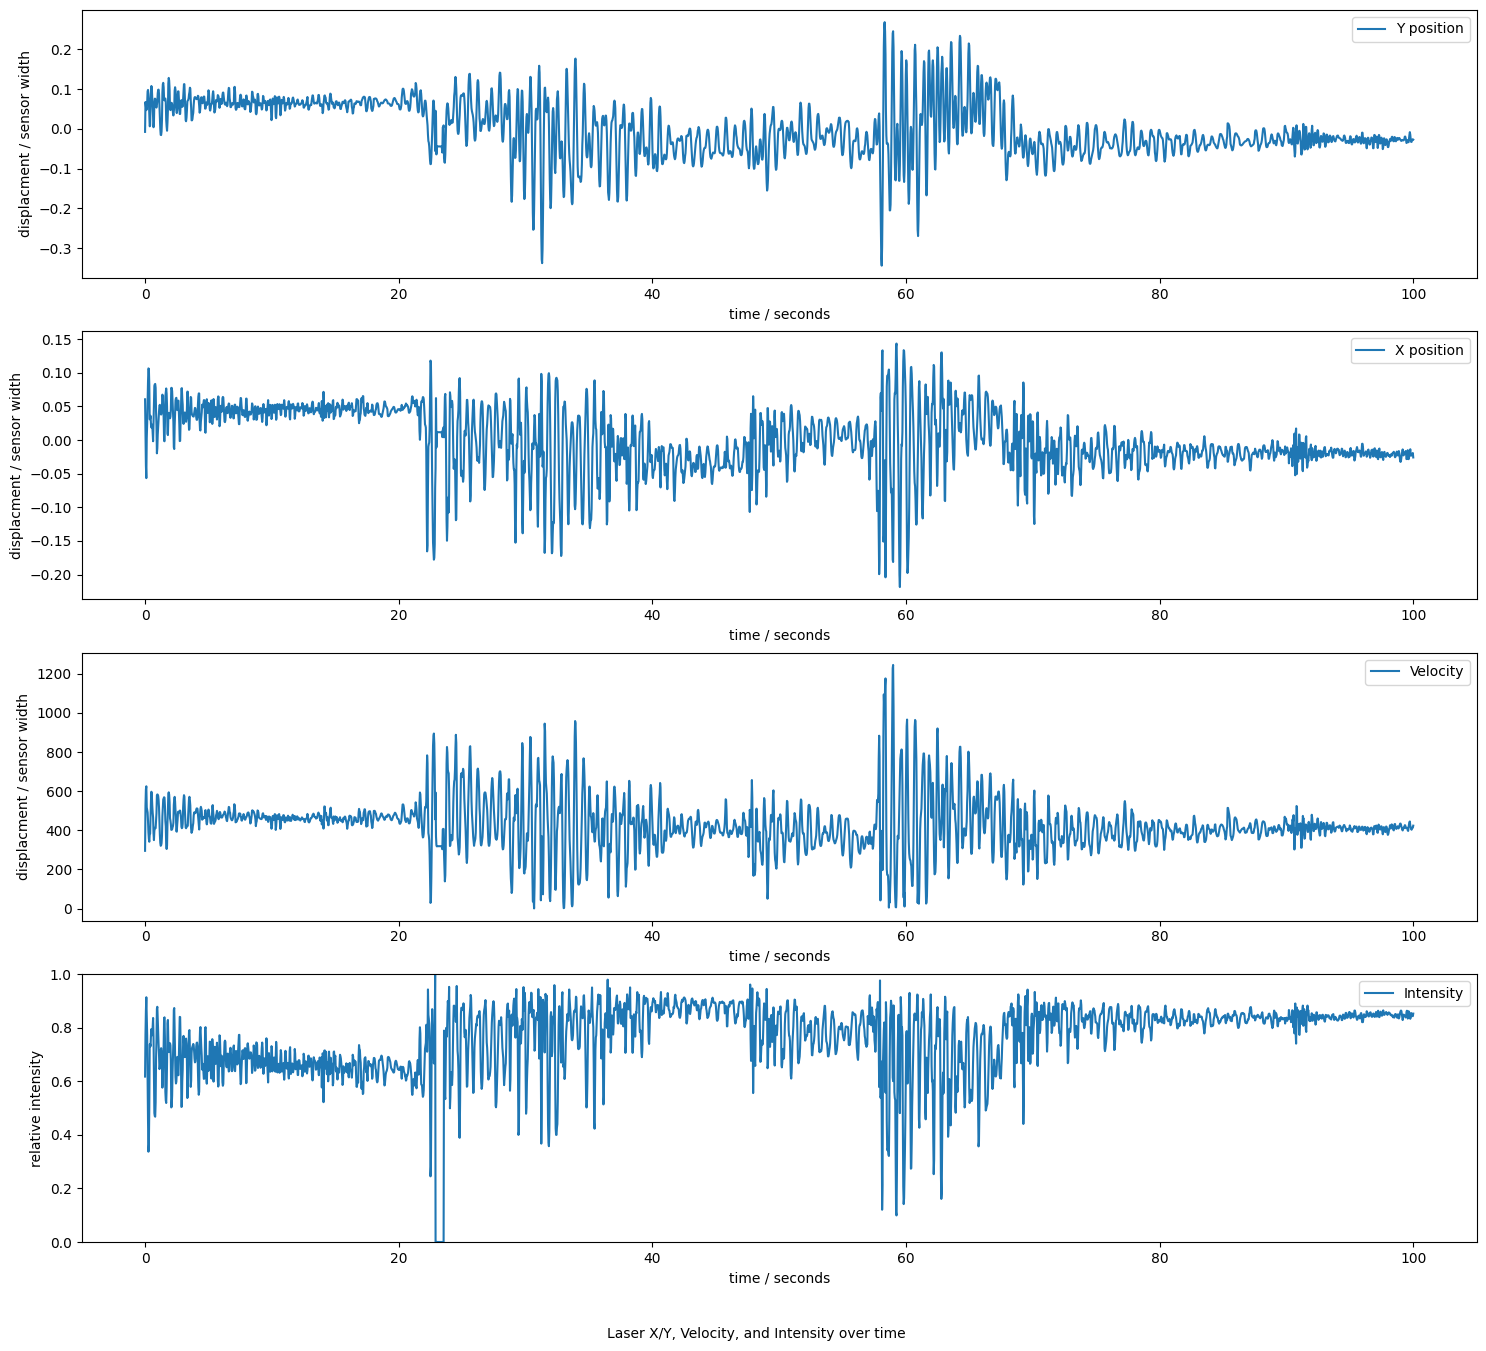

In [193]:
fig, ax = plt.subplots(4, 1, figsize=(18, 16))
ax_displacement = ax[0:3]
ax_intensity = ax[3]

ax_displacement[0].plot(time_axis, laser_displacement_zeroed[:, 0] / frame_width, label="Y position")
ax_displacement[1].plot(time_axis, laser_displacement_zeroed[:, 1] / frame_width, label="X position")
ax_displacement[2].plot(time_axis, velocity_abs, label="Velocity")
for ax_d in ax_displacement:
    ax_d.set_xlabel("time / seconds")
    ax_d.set_ylabel("displacment / sensor width")
    ax_d.legend()

ax_intensity.plot(time_axis, laser_intensity, label="Intensity")
ax_intensity.set_xlabel("time / seconds")
ax_intensity.set_ylabel("relative intensity")
ax_intensity.set_ylim(0, 1)
ax_intensity.legend()

fig.text(0.5, 0.05, "Laser X/Y, Velocity, and Intensity over time", ha="center")
pass

In [217]:
from scipy import signal

fx, psd_x = signal.periodogram(np.nan_to_num(laser_position[:, 1]), frame_rate)
fy, psd_y = signal.periodogram(np.nan_to_num(laser_position[:, 0]), frame_rate)

## Spectral Analysis
The following figure looks at the spectral density in the displacement along X and Y axis.  This gives us a good insight to see which vibration frequencies were transmitted through the isolation.

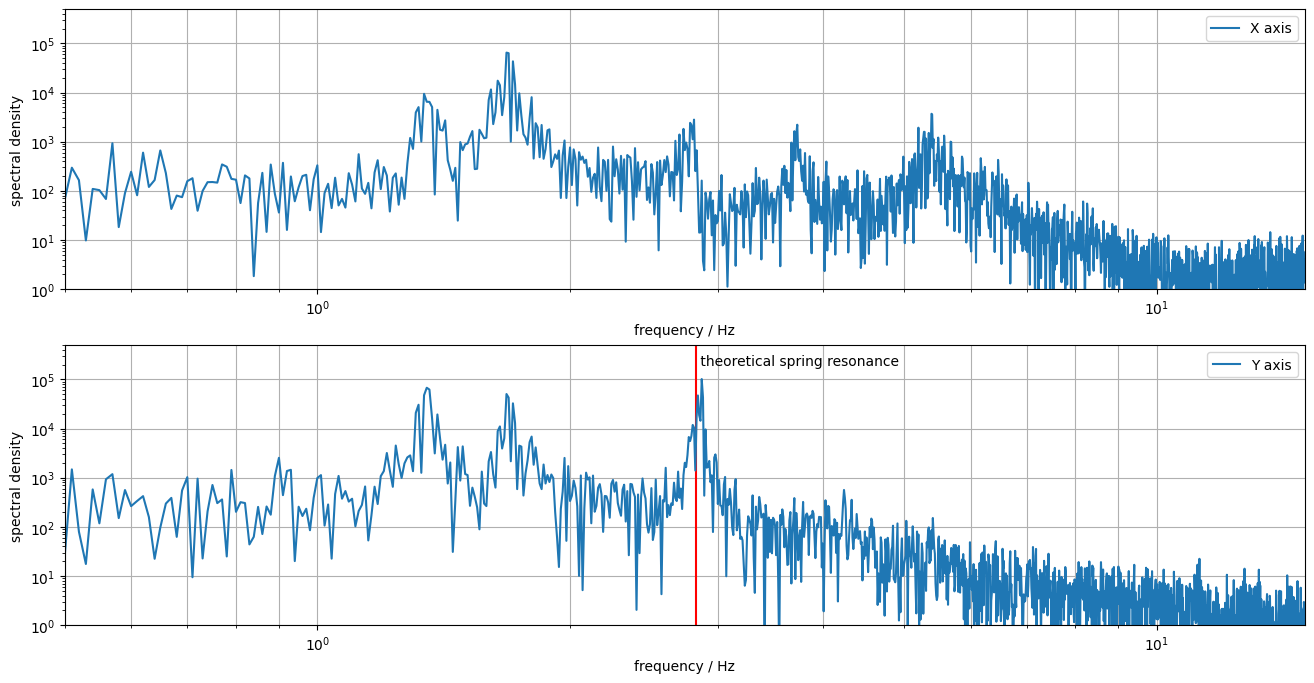

In [218]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

ax[1].axvline(x=2.822, color="red")
ax[1].annotate(" theoretical spring resonance", xy=(2.822, 2e5))

ax[0].loglog(fx, psd_x, label="X axis")
ax[1].loglog(fy, psd_y, label="Y axis")
for a in ax:
    a.set_xlabel("frequency / Hz")
    a.set_ylabel("spectral density")
    a.set_xlim(0.5, 15)
    a.set_ylim(1, 5e5)
    a.legend()
    a.grid(axis="x", which="both")
    a.grid(axis="y", which="major")

pass

Of note is the highlighted _theoretical spring resonance_ which we had previously calculated using the known spring constant and mass of the system.  Seeing a very visible peak at this frequency along the Y axis (the axis of the springs) is very nice.

In [172]:
# np.save("./laser-results/2025-09-07-011400-analyzed.npy", laser_position)